In [1]:
%matplotlib inline
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(rc={'figure.figsize':(11.7,8.27)})

# Historical Weather Demo

This is part of a simple demo command line interface app to analyse historical weather data using pandas. I put this notebook to inspect the data and prototype the code.

In [2]:
# nit-picking: Snow and rain are both types of precipitation, so it seems weird that there are non-zero `SNOW` values on days with zero `PRCP`
def extract_data(csv_path: str) -> pd.DataFrame:
    """
    Read in the csv data, parse dates, and set index to DATE column. This function assumes
    that the input has a column called 'DATE' than can be parsed into datetime objects.

    Args:
        csv_path (str): The path to the provided csv data.

    Returns:
        df (pd.DataFrame): Pandas dataframe representation of the csv file with datetime index.
    """
    df = pd.read_csv(csv_path, parse_dates=['DATE'])
    df = df.set_index('DATE').sort_index()
    return df

In [3]:
df = extract_data('data/noaa_historical_weather_10yr.csv')

In [4]:
df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
DATE,,,,,,,,,,,,,,,,,,
2010-01-01,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",25.7881,-80.3169,8.8,3.0,1515.0,1505.0,3.3,NaN,NaN,NaN,27.2,13.9,290,280.0,10.7,17.4
2010-01-01,USW00025309,"JUNEAU AIRPORT, AK US",58.3566,-134.5640,4.9,2.3,1346.0,1345.0,0.0,0.0,0.0,NaN,-6.1,-12.8,130,120.0,6.7,9.4
2010-01-01,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,3.4,2359.0,2344.0,0.0,0.0,NaN,NaN,1.7,-3.3,350,350.0,6.7,8.9
2010-01-02,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",25.7881,-80.3169,8.8,3.8,533.0,523.0,0.0,NaN,NaN,NaN,18.3,9.4,340,320.0,7.2,10.7
2010-01-02,USW00025309,"JUNEAU AIRPORT, AK US",58.3566,-134.5640,4.9,2.8,1515.0,1514.0,0.0,0.0,0.0,NaN,-7.2,-10.0,110,100.0,5.8,6.7


## Data Checks

This one is a nit pick, but snow is a type of precipitation so, really, there shouldn't be non-zero snow measurements on days with zero precipitation. ...but there are. So maybe `PRCP` really translates to rain rather than to precipitation? This question could probably be solved by poking around NOAA's Climate Data Online tool for detailed metadata, but for the purpose of this assignment I'll assume that `SNOW` + `PRCP` = total_precipitation.

In [5]:
df[df.PRCP == 0].SNOW.max()

np.float64(36.0)

Do we have the expected number of rows for each year in each city (366 for leap years)? Yes, looks like we do. ...and, speaking of leap years, they will cause a bit of weirdness when trying to do "day of the year" alignment. In otherwords day 60 is March 1st on a normal year, but it's February 29th on a leap year. So when we calculate day of the year averages across the years there's a misalignment after day 60. I think I'm just going to ignore this for now.

In [6]:
df.groupby(['NAME', df.index.year])['PRCP'].count()

NAME                                DATE
BOSTON, MA US                       2010    365
                                    2011    365
                                    2012    366
                                    2013    365
                                    2014    365
                                    2015    365
                                    2016    366
                                    2017    365
                                    2018    365
                                    2019    365
JUNEAU AIRPORT, AK US               2010    365
                                    2011    365
                                    2012    366
                                    2013    365
                                    2014    365
                                    2015    365
                                    2016    366
                                    2017    365
                                    2018    365
                                    2019    365

In [7]:
df.SNOW.isna().sum(), df.PRCP.isna().sum()

(np.int64(2881), np.int64(0))

Do the data look kind of like we'd expect when plotted?

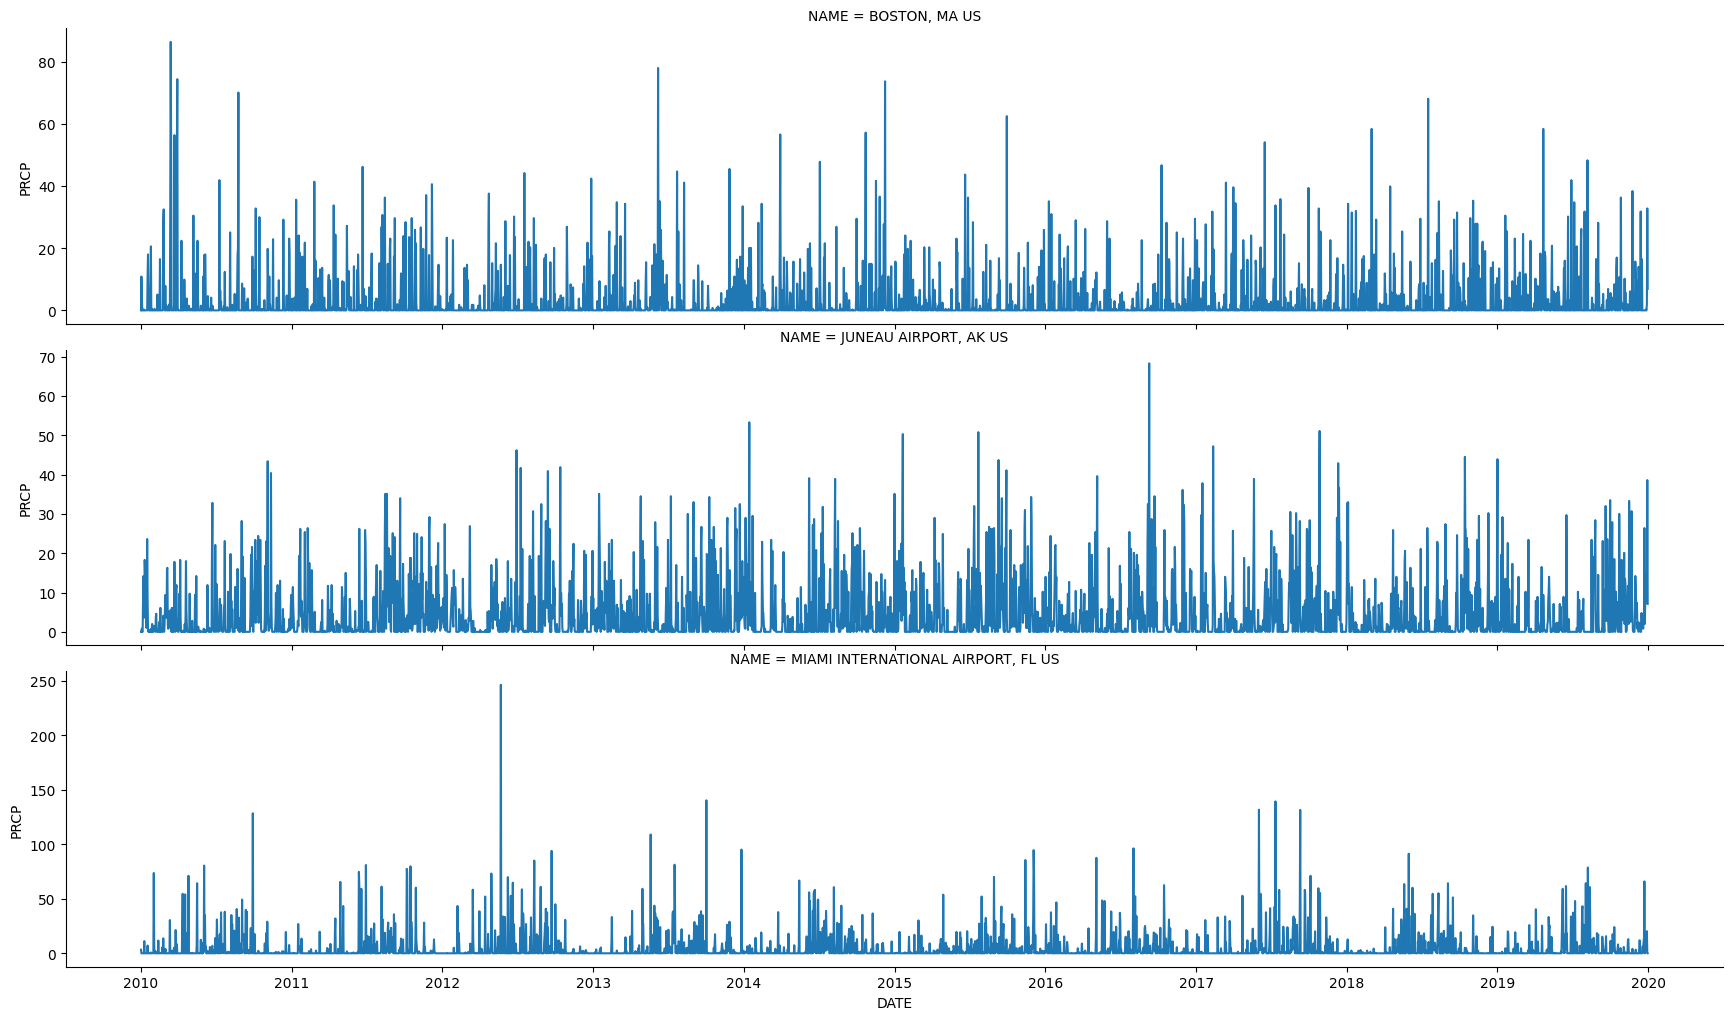

In [8]:
g = sns.relplot(
    data=df.sort_values('NAME'),
    x='DATE',
    y='PRCP',
    col='NAME',
    kind='line',
    col_wrap=1,
    facet_kws={'sharey': False, 'sharex': True}
)
g.fig.set_size_inches(20, 10);

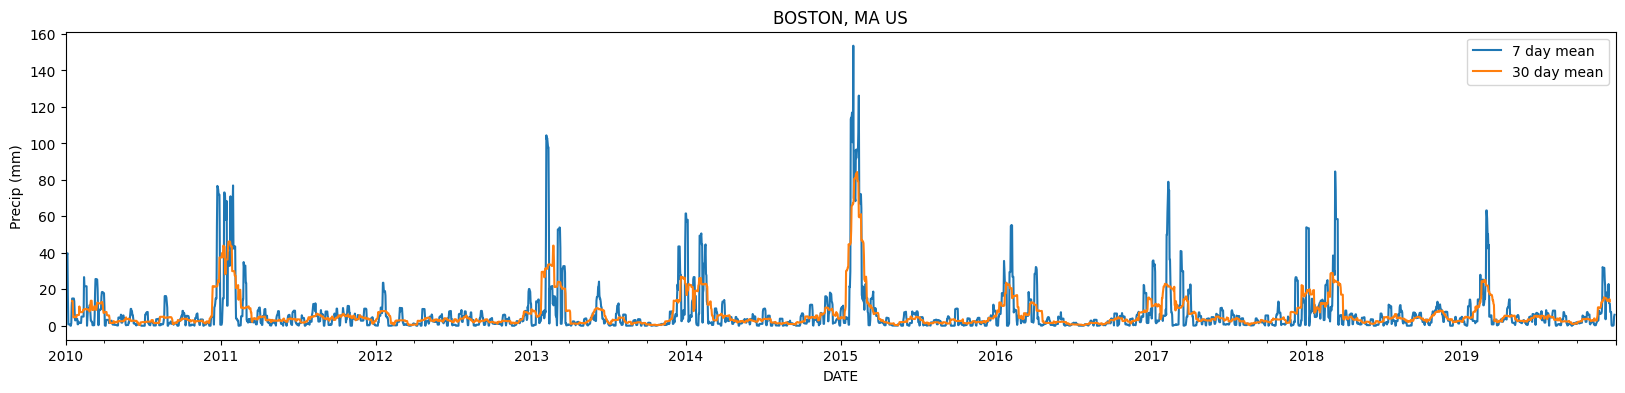

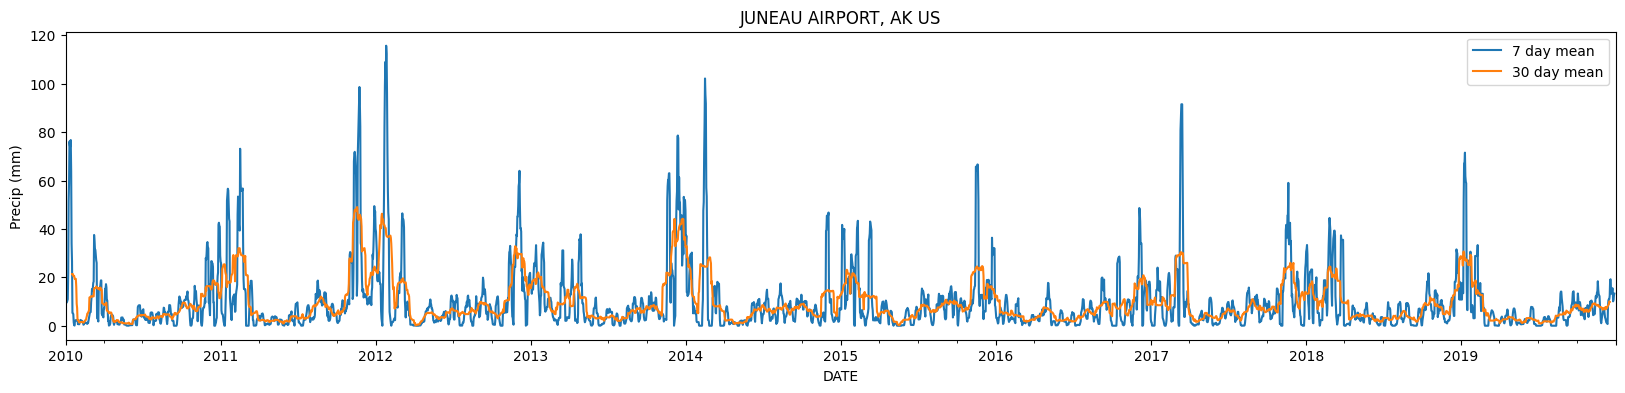

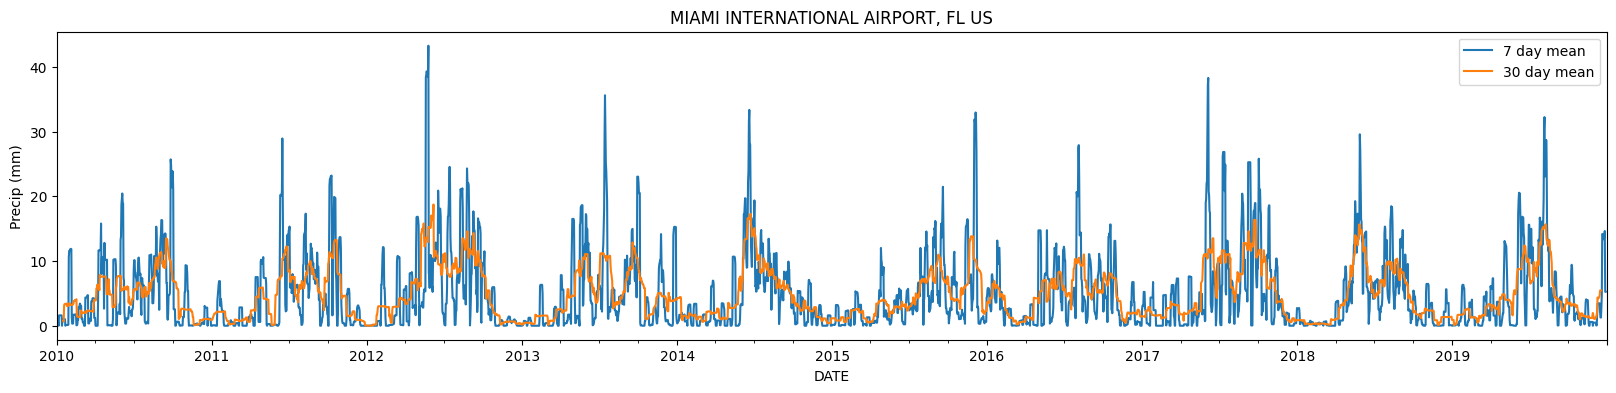

In [9]:
for name in sorted(df.NAME.unique()):
    df_roll = df.query('NAME == @name').copy()
    df_roll['total_precip'] = df_roll.PRCP + df_roll.SNOW.fillna(0.0)
    df_roll['mean_precip'] = df_roll.total_precip.rolling(7, center=True).mean()
    ax = df_roll.mean_precip.plot(figsize=(20, 4), label='7 day mean')
    ax = df_roll.total_precip.rolling(30, center=True).mean().plot(ax=ax, label='30 day mean')
    ax.set_title(name)
    ax.set_ylabel('Precip (mm)')
    ax.legend()
    plt.show()

In [10]:
def add_measurable_precip(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add column with a boolean indicator of whether or not there was precipiation or snow on a 
    given day. To give correct results, this should only be run on subsets of data that 
    contain only a single location. In other words, this should be run from within the 
    `augment_data` function rather than directly on the full dataset.

    Args:
        df (pd.DataFrame): A single city subset of the pandas dataframe representation of the 
            csv file with datetime index.

    Returns:
        df_out (pd.DataFrame): Same dataframe with additional column called `had_precipitation`.
    """
    df_out = df.copy()
    df_out['had_precipitation'] = (df_out.PRCP > 0) | (df_out.SNOW > 0)
    return df_out


def augment_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a boolean column called `had_precipitation` that indicates if snow or rain was 
    greater than zero on a given day (for a particular city). Also add a `city` column that has a 
    3 letter abbreviation derived from `NAME`.

    Args:
        df (pd.DataFrame): DataFrame of historical precipitation data as output by the `extract_data` 
            function.

    Returns:
        df_out (pd.DataFrame): The input dataset with added `city` and `had_precipitation` columns.
    """
    df_out = df.copy()
    df_out['city'] = df_out.NAME.str[:3].str.upper().replace('JUN', 'JNU')
    grp = df_out.groupby('city')
    df_out = grp.apply(add_measurable_precip, include_groups=False).reset_index(level='city')
    return df_out


def day_of_year_probability(df: pd.DataFrame, roll_period='30D') -> pd.DataFrame:
    """
    Transform the input dataframe into a dataframe of probability of precipitation for each location.

    Args:
        df (pd.DataFrame): DataFrame of historical precipitation data as output by the `extract_data` 
            function and augmented by the `augment_data` function.
        roll_period (str): Size of the moving window. If an integer, the fixed number of observations 
            used for each window. If a timedelta, str, or offset, the time period of each window. Each 
            window will be a variable sized based on the observations included in the time-period. This is 
            only valid for datetimelike indexes. To learn more about the offsets & frequency strings, please 
            see this [link](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

    Returns:
        df_out (pd.DataFrame): A pandas dataframe with days of the year as index (1 - 366) and cities
            as columns. The values represent the estimated probability of precipitation for a given
            city on a given day of the year.
    """
    df_out = df.copy()
    # Group by city then calculate the rolling mean of the boolean `had_precipitation` flag.
    # This will smooth the short term fluctuations to make seasonal trends more apparent.
    df_out = df_out.groupby('city').had_precipitation.rolling(roll_period, center=True).mean()
    # Unstack the resulting multi index so that each city is in a column
    df_out = df_out.unstack('city')
    # Get the mean (across all years) for each day of the year.
    df_out = df_out.groupby(df_out.index.day_of_year).mean()
    return df_out


def days_of_precip(
    df: pd.DataFrame,
    city: str,
) -> str:
    """
    Calculate the average (i.e., mean) number of days per year the given city had non-zero 
    precipitation (either rain or snow) based on the entire 10 year period.

    Args:
        df (pd.DataFrame): DataFrame of historical precipitation data as output by the `extract_data` 
            function and augmented by the `augment_data` function.
        city (str): The name of the city to calculate values for. Expected values are bos, jun, or mia.

    Returns:
        str: JSON representation of the name of the `city` (str) and mean `days_of_precip` (float) 
            for that city.
    """
    # Limit our data frame to the city of interest
    city_df = df.query("city == @city")
    # Group precip boolean by year, sum to find total days for each year, then get the mean across years
    mean_days = city_df['had_precipitation'].groupby(city_df.index.year).sum().mean()
    # Format the output as json
    json_out = json.dumps(dict(city=city, days_of_precip=mean_days))
    
    return json_out


def chance_of_precip(
    df: pd.DataFrame,
    city: str,
    month: int,
    day: int=0,
) -> str:
    """
    Given the provided dataset, predict how likely it is a given city will experience rain or snow
    for a given month or day. Just please don't ask for February 29th.

    Args:
        df (pd.DataFrame): DataFrame of historical precipitation data as output by the `extract_data` 
            function and augmented by the `augment_data` function.
        city (str): The name of the city to calculate values for. Expected values are bos, jun, or mia.
        month (int): Month to use for the prediction. Expected values 1 - 12.
        day (int, optional): Day to use for prediction. Expected values 1 - 31. If left out (or 0), 
            then the prediction will be for the whole month.

    Returns:
        str: JSON representation of the `city` (str) and `precipitation_likelihood` (float) for that city.
    
    """
    # Convert to day of year probability
    doy_prob = day_of_year_probability(df)

    if day:
        # Just need to look up value for day and city.
        doy = pd.to_datetime(f'{month}-{day}', format='%m-%d').day_of_year
        prob = doy_prob.loc[doy, city]
    else:
        # get start and end day of year from month
        p = pd.Period(pd.to_datetime(month, format='%m'), 'M')
        start = p.to_timestamp(how='start').day_of_year
        end = p.to_timestamp(how='end').day_of_year
        # get series of daily PoP (probability of precipitation)
        daily_pop = doy_prob.loc[slice(start, end), city]
        # To figure out how likely it is to rain at least once during the whole month
        # we will first figure out how likely it is that it won't rain at all.
        prob_no_rain = (1 - daily_pop).prod()
        # Convert to probability that it will rain at least once
        prob = 1 - prob_no_rain

    return prob

In [11]:
df2 = augment_data(df)

In [12]:
df2.head()

,city,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,had_precipitation
DATE,,,,,,,,,,,,,,,,,,,,
2010-01-01,BOS,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,3.4,2359.0,2344.0,0.0,0.0,NaN,NaN,1.7,-3.3,350,350.0,6.7,8.9,False
2010-01-02,BOS,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,6.9,2300.0,2300.0,10.9,163.0,NaN,NaN,-1.1,-6.1,300,300.0,13.4,17.0,True
2010-01-03,BOS,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,9.3,158.0,456.0,5.1,94.0,NaN,NaN,-0.6,-8.3,290,280.0,13.9,18.3,True
2010-01-04,BOS,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,7.0,851.0,808.0,0.0,0.0,NaN,NaN,1.7,-3.3,300,290.0,10.3,13.9,False
2010-01-05,BOS,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,4.5,2329.0,2328.0,0.0,0.0,NaN,NaN,1.1,-2.8,320,320.0,7.6,10.7,False


## Average Days of Precipitation per year

> "Calculate the average number of days per year the given city had non-zero precipitation (either snow or rain) based on the entire 10 year period"

In [13]:
grp = df2.groupby(['city', df2.index.year])
city_sums = grp['had_precipitation'].sum()
city_sums

city  DATE
BOS   2010    112
      2011    138
      2012    123
      2013    129
      2014    131
      2015    123
      2016    120
      2017    139
      2018    145
      2019    156
JNU   2010    218
      2011    239
      2012    232
      2013    240
      2014    217
      2015    235
      2016    221
      2017    215
      2018    207
      2019    200
MIA   2010    130
      2011    131
      2012    148
      2013    146
      2014    146
      2015    165
      2016    154
      2017    130
      2018    143
      2019    155
Name: had_precipitation, dtype: int64

In [14]:
city_sums.groupby('city').mean()

city
BOS    131.6
JNU    222.4
MIA    144.8
Name: had_precipitation, dtype: float64

#### Sanity check comparison with questionable ground truth data

The internet says 230 days for Juneau, 137 days, and 128 days for [Miami](https://www.usclimatedata.com/climate/miami/florida/united-states/usfl0316). ...but [a different source](https://weatherspark.com/y/146868/Average-Weather-at-Miami-International-Airport-Florida-United-States-Year-Round) says 156 days of rain at MIA airport. I spent almost no time vetting my sources, but it seems like I'm somewhere in the vacinity of more rigorous estimates.

### Function Test

Test the function I wrote to make sure it gives expected results.

In [15]:
days_of_precip(df2, 'BOS'), days_of_precip(df2, 'JNU'), days_of_precip(df2, 'MIA')

('{"city": "BOS", "days_of_precip": 131.6}',
 '{"city": "JNU", "days_of_precip": 222.4}',
 '{"city": "MIA", "days_of_precip": 144.8}')

### A little more exploration for monthly and daily probabilities

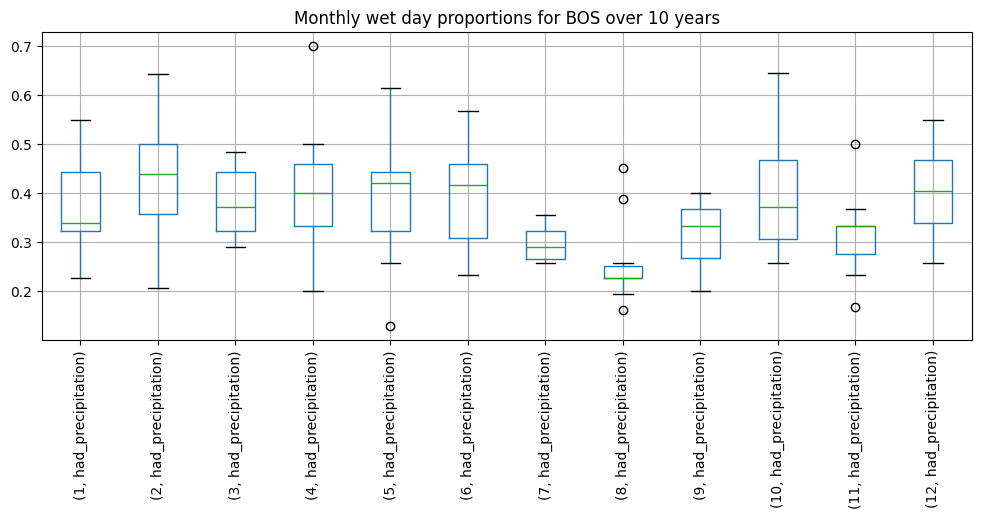

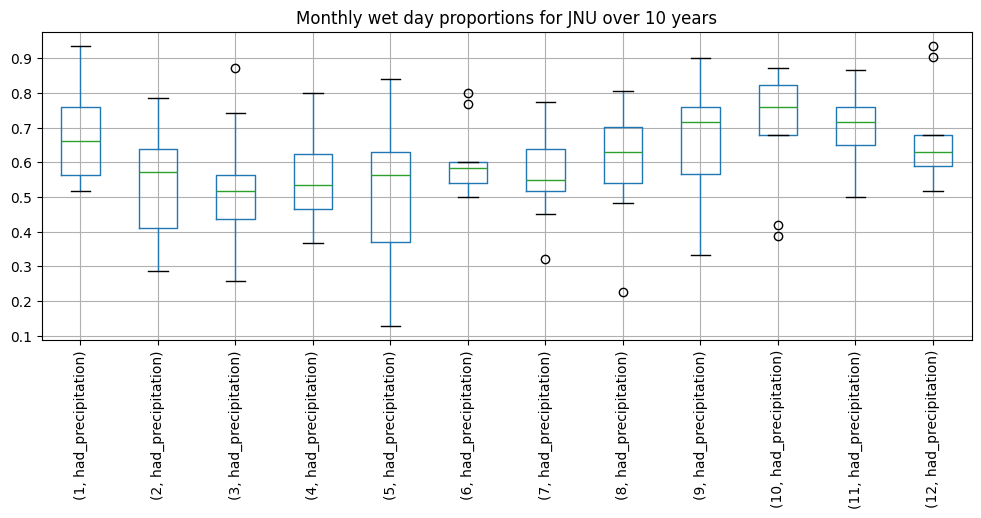

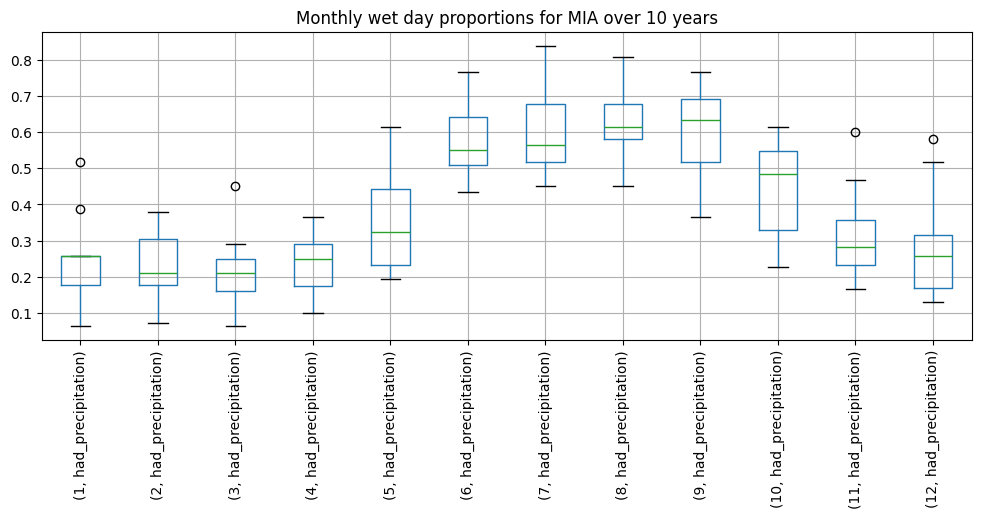

In [16]:
city = 'BOS'
for city in ['BOS', 'JNU', 'MIA']:
    # city subset
    city_df = df2.copy().query("city == @city")
    # get the mean number of wet days per month for each month over ten years
    foo = city_df.had_precipitation.resample('MS').mean()
    # groups those means by month so we can box plot the distribution of means for each month across all years
    ax = pd.DataFrame(foo).groupby(foo.index.month).boxplot(subplots=False, rot=90, figsize=(12, 4))
    ax.set_title(f"Monthly wet day proportions for {city} over 10 years");
    plt.show();

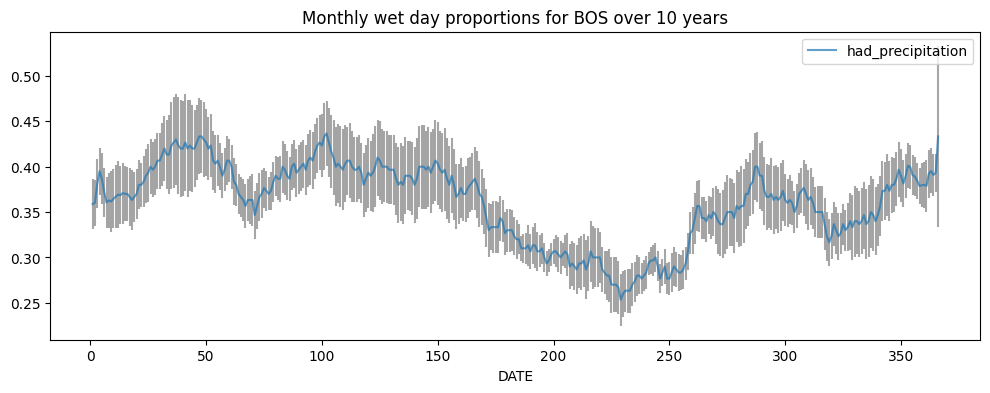

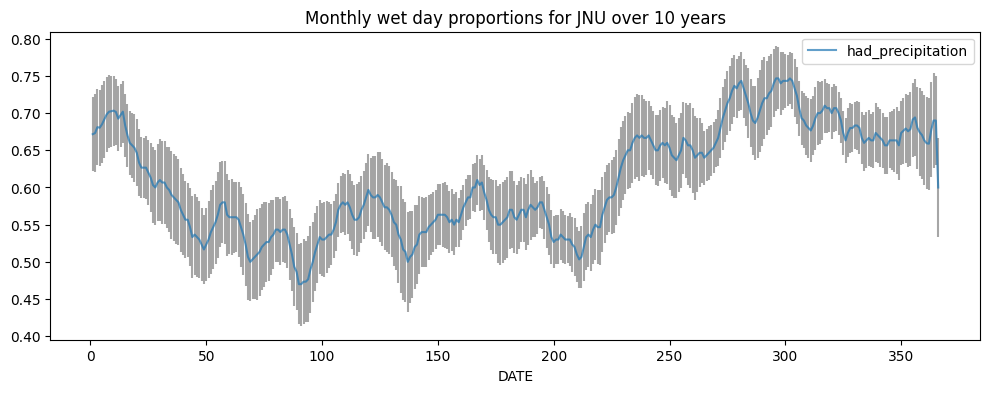

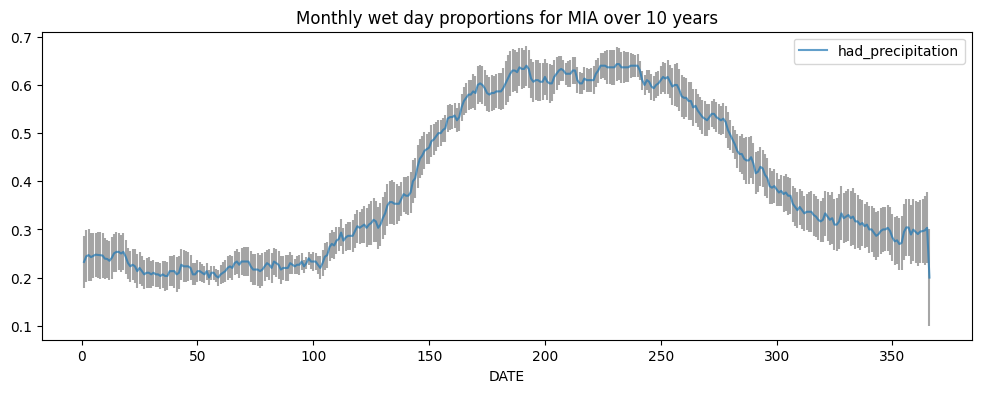

In [17]:
roll_period = '30D'
for city in ['BOS', 'JNU', 'MIA']:
    # city subset
    city_df = df2.copy().query("city == @city")
    # get rolling mean of binary flag, aka windowed probability of precip
    roller = city_df.had_precipitation.rolling(roll_period, center=True)
    roll_mean = roller.mean()
    # group those probabilities by day of year (groups of 10 values)
    g = pd.DataFrame(roll_mean).groupby(roll_mean.index.day_of_year)
    # plot the mean of daily values with SEM
    ax = g.mean().plot(yerr=g.sem(), ecolor='gray', alpha=0.7, figsize=(12, 4))
    ax.set_title(f"Monthly wet day proportions for {city} over 10 years");
    plt.show();

Simplify the calculation

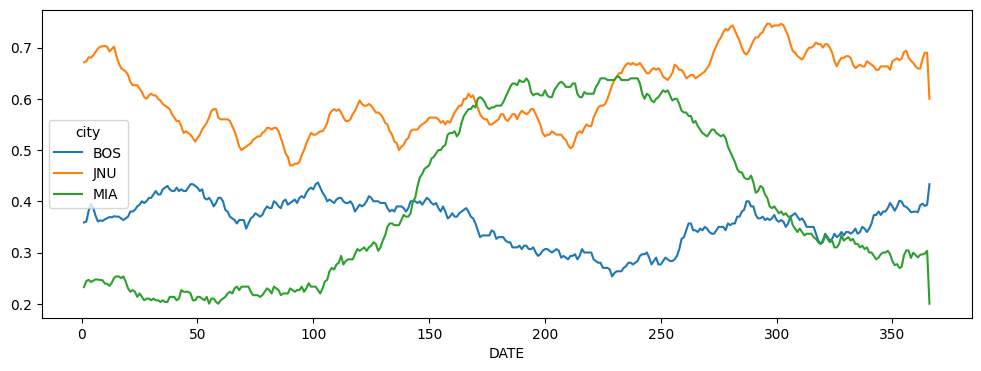

In [18]:
roll_period = '30D'
foo = df2.groupby('city').had_precipitation.rolling(roll_period, center=True).mean().unstack('city')
ax = foo.groupby(foo.index.day_of_year).mean().plot(figsize=(12, 4))

Have there been any months with no rain in any of the cities over all ten years of data?

In [19]:
df2.groupby(['city', pd.Grouper(df2, freq='ME')]).PRCP.sum().groupby('city').min()

city
BOS    15.7
JNU    13.3
MIA     4.8
Name: PRCP, dtype: float64

Nope, to that tracks with the very high probabilities I'm getting for having at least one rainy day per month.

In [20]:
chance_of_precip(df2, 'MIA', 3, 0)
    

np.float64(0.9996015521186226)